![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Reprojecting datacube and raster data

 - Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with teh default environment 

 - <b>Products used</b>:
    - Sentinel 2 surface reflectance: `s2_l2a`
    - NASA DEM: `nasadem`


## Background


It is often valuable to combine data from the datacube with other external raster datasets. However, it can be challenging to combine datasets if they have different extents, resolutions (e.g. 30 m vs. 250 m), or coordinate reference systems (e.g. WGS 84 vs. NAD83 2011). To be able to combine these datasets, we need to be able to reproject them into identical spatial grids prior to analysis.

Datacube stores information about the location, resolution and coordinate reference system of a rectangular grid of data using an object called a `GeoBox`. This [GeoBox object](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.geometry.GeoBox.html) is dynamically calculated for all data loaded from the datacube, and all rasters loaded with `xr.open_rasterio` (provided that `import datacube` is run before the raster is loaded). Datacube functions can use this object to provide a template that can be used to reproject raster and datacube data - either applying this reprojection directly when new data is being loaded, or to reproject existing data that has already been loaded into memory. This makes it straightforward to reproject one dataset into the exact spatial grid of another dataset for further analysis.

## Description

This notebook demonstrates how to perform two key reprojection workflows when working with datacube data and external rasters:

1. Loading and reprojecting datacube data to match a raster file using `dc.load`
2. Reprojecting existing datacube data to match a raster using `xr_reproject`


---------------------------------------------------------------------------------------------------------------------------

## Getting started


To run this analysis, run all the cells in the notebook, starting with the “Load packages” cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [3]:
import datacube
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.masking import mask_invalid_data
from matplotlib.colors import LightSource
import numpy as np
import sys
import rasterio as rio
from rasterio.transform import from_bounds
# from deafrica_tools
from deafrica_tools.plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [16]:
dc = datacube.Datacube(app='ReprojectingData')

# Loading and reprojecting datacube data to match a raster¶

## Load a raster file

First we load a GeoTIFF raster from file using `xr.open_rasterio`. 

The example below is from this [Microsoft website](https://planetarycomputer.microsoft.com/dataset/nasadem) and is in the WGS 84 (`EPSG:4326`) coordinate reference system.


In [17]:
# Load the raster 
data = dc.load(product="nasadem", 
               resolution=(-0.01, 0.01), 
               lon=(-77,-76), lat=(36.5,37.5))

data

/opt/tljh/user/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)


<xarray.Dataset>
Dimensions:      (time: 1, latitude: 100, longitude: 100)
Coordinates:
  * time         (time) datetime64[ns] 2000-02-20
  * latitude     (latitude) float64 37.49 37.48 37.47 37.46 ... 36.52 36.52 36.5
  * longitude    (longitude) float64 -77.0 -76.98 -76.98 ... -76.02 -76.01
    spatial_ref  int32 4326
Data variables:
    elevation    (time, latitude, longitude) int16 24 33 33 23 32 ... 0 0 1 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

If we plot our loaded raster, we can see Hampton Roads and the surrounding coastal zone of southern Virginia. In the dark areas lie areas of low elevation and nearby areas of higher elevation as brighter pixels. 

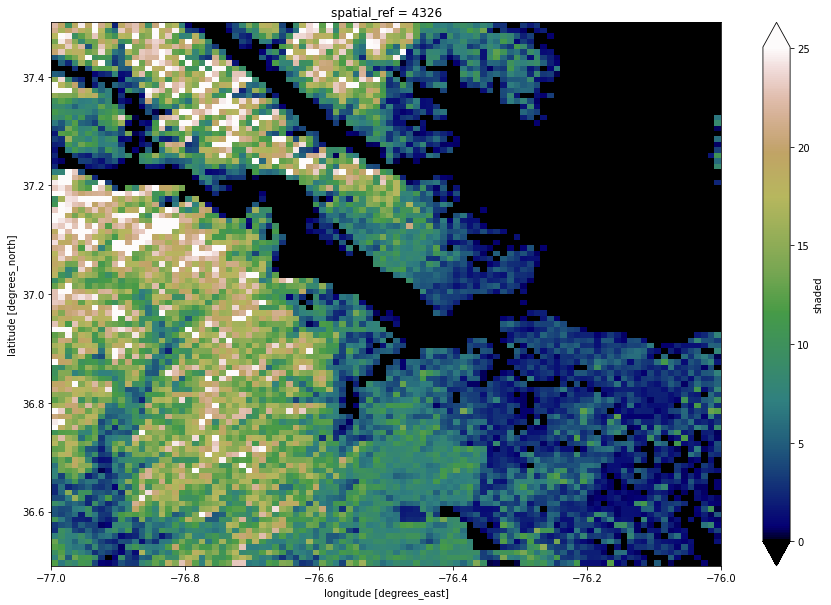

In [18]:
#Plot it

# Sample elevation array
elevation = data.elevation.isel(time=0).values

# Create hillsahde based on the array
ls = LightSource(azdeg=315, altdeg=45)
dyx = 10
shade = ls.hillshade(elevation, vert_exag=0.5, dx=dyx, dy=dyx, fraction=1.0)

# Modify the original elevation data to include shade
data['shaded'] = (['latitude', 'longitude'], elevation * shade)

# Plot using bilinear interpolation to remove artefacts
data.shaded.plot(size=10, robust=True, cmap="gist_earth")


### GeoBox objects

Now we have loaded our raster dataset, we can inspect its `GeoBox` object that we will use to allow us to reproject data. The `GeoBox` can be accessed using the `.geobox` method. It includes a set of information that together completely define the spatial grid of our data: * The width (e.g. `1000`) and height (e.g. `1000`) of our data in pixels; an Affine object which defines the spatial resolution (e.g. `0.0009999999999999953` and `-0.0010000000000000024`) and spatial position (e.g. `-77.0` and `37.5`) of our data; and, the coordinate reference system of our data (e.g. `+init=epsg:4326`)

<b>Note:</b> For more information about `GeoBox` objects and a complete list of their methods, refer to the [datacube documentation](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.geometry.GeoBox.html#).

In [50]:
# call the geobox
data.geobox

GeoBox(100, 100, Affine(0.009999999999999948, 0.0, -77.0,
       0.0, -0.01000000000000002, 37.5), GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]])

### Load and reproject datacube data

We can now use datacube to load and reproject satellite data to exactly match the coordinate reference system and resolution of our raster data. By specifying `like=raster.geobox`, we can load datacube data that will be reprojected to match the spatial grid of our raster.

In [51]:
# Load and reproject data from datacube
ds = dc.load(product="s2_l2a",
             measurements=["red", "green", "blue"], #bands 
             time=("2019-06-15", "2019-06-15"), #when the images took place
             like=data.geobox, #here you can make sure other data cube products line up with another's geobox and extent, as explored above
             resampling="nearest", #resampling method
             group_by="solar_day")

When we plot the result, it should appear similarly pixelated to the low resolution raster we loaded above:

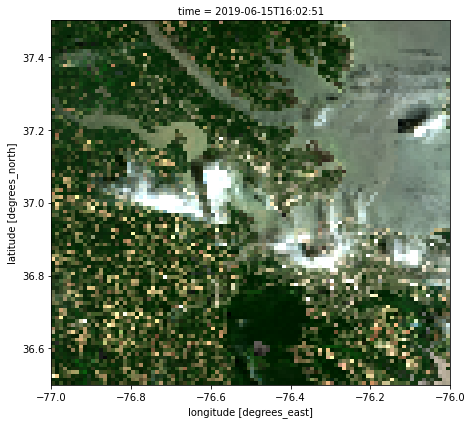

In [52]:
rgb(ds, col='time')

We can also directly compare the geobox of the two datasets to verify they share the same spatial grid:

In [53]:
ds.geobox == data.geobox

True

## Reprojecting existing datacube data to match a raster

The example above demonstrated how to load <i>new</i> satellite data from the datacube to match the spatial grid of a raster. However, sometimes we may have already loaded satellite data with a coordinate reference system and resolution that is different from our raster. In this case, we need to reproject this existing dataset to match our raster.


For example, we may have loaded Sentinal 2 data from the datacube with 10 m pixels in the NAD83 2011 (`EPSG:6318`) coordinate reference system (note that in this example we manually specify the `x`, `y`, `resolution` and `output_crs` parameters, rather than taking them directly from our raster using `like=raster.geobox` in the previous example).

<xarray.Dataset>
Dimensions:      (time: 1, y: 14371, x: 9650)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-15T16:02:51
  * y            (y) float64 4.457e+06 4.457e+06 ... 4.313e+06 4.313e+06
  * x            (x) float64 -7.429e+06 -7.429e+06 ... -7.333e+06 -7.333e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 226 227 237 234 237 ... 1428 1368 1408 1450
    green        (time, y, x) uint16 494 510 468 513 505 ... 1502 1426 1424 1490
    blue         (time, y, x) uint16 242 249 252 249 272 ... 1322 1222 1234 1318
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


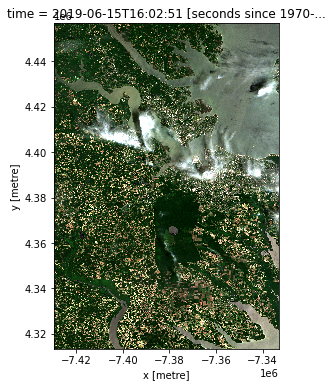

In [54]:
# Load and reproject data from datacube
ds = dc.load(product="s2_l2a",
             measurements=["red", "green", "blue"], #bands 
             time=("2019-06-15", "2019-06-15"), #when the images took place
             x=(-77.0,-76.0),
             y=(36.1,37.5),
             output_crs="epsg:6933", #coordinate reference system
             resolution=(-10,10),
            group_by="solar_day")


print(ds)
#plot it and notice the resolution
rgb(ds)

### Reproject datacube data

We can now use the `xr_reproject` function to reproject our existing high resolution satellite dataset. We pass `data.geobox` to the function to request that the data gets reprojected to match the spatial grid of our low resolution raster.

To control how the data is reprojected, we can specify a custom `resampling` method that will control how our high resolution pixels will be transformed into lower resolution pixels. In this case, we specify `"average"`, which will set the value of each larger pixel to the average of all smaller pixels that fall within its pixel boundary.

<b>Note:</b> Refer to the [rasterio](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) documentation for a full list of available resampling methods.

In [55]:
# Reproject data
ds_reprojected = xr_reproject(ds, data.geobox, resampling="average")

# Set nodata to `NaN`
ds_reprojected = mask_invalid_data(ds_reprojected)

Now if we plot our reprojected dataset, we can see that our satellite imagery now has a similar resolution to our low resolution raster (e.g. with a pixelated appearance). Note however, that this result will appear smoother than the previous example due to the `"average"` resampling method used here (compared to `"nearest"`.

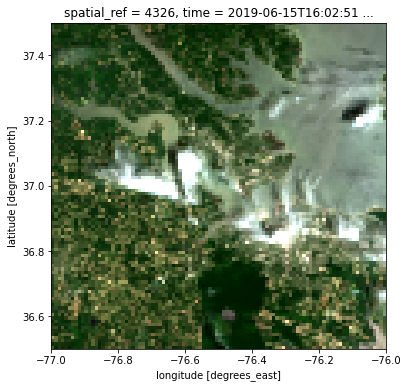

In [56]:
rgb(ds_reprojected)

***

## Additional information

Notebook copied from https://docs.dea.ga.gov.au/notebooks/How_to_guides/Reprojecting_data.html?highlight=reprojecting

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 


**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2023

**Compatible datacube version:** 

In [4]:
print(datacube.__version__)

1.8.6


## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 